In [1]:
import numpy as np
from OpenEphys import loadContinuous
import os
import glob
from scipy import signal as ss
from scipy import stats as st
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Select file for analysis
files_to_be_converted = ['Pre 1','Pre 2','Pre 3','Cit 1','Cit 2','Cit 3','Way 1', 'Way 2','Way 3']
source_folder = r'/Users/sharplab/tran/EEG data'

path = "/".join([source_folder,files_to_be_converted[0]])
os.chdir(path)
file = glob.glob("*.continuous")
print(file[0])
eegdata = loadContinuous(file[0], dtype=float)
array = eegdata['data']

#Functions for filters
def butter_lowpass(low_cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_low_cutoff = low_cutoff / nyq
    b_low, a_low = butter(order, normal_low_cutoff, btype='low', analog=False)
    return b_low, a_low

def butter_highpass(high_cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_high_cutoff = high_cutoff / nyq
    b_high, a_high = butter(order, normal_high_cutoff, btype='high', analog=False)
    return b_high, a_high

def butter_lowpass_filter(data, low_cutoff, fs, order=5):
    b_low, a_low = butter_lowpass(low_cutoff, fs, order=order)
    y_low = lfilter(b_low, a_low, data)
    return y_low

def butter_highpass_filter(data, high_cutoff, fs, order=5):
    b_high, a_high = butter_lowpass(high_cutoff, fs, order=order)
    y_high = lfilter(b_high, a_high, data)
    return y_high

# Filter requirements.
order = 5
fs = 30000.0       # sample rate, Hz
low_cutoff = 100 # desired cutoff frequency of the filter, Hz
high_cutoff = 0.1


# Filter the data.
print('Filtering data')
filtered_array = butter_lowpass_filter(array, low_cutoff, fs, order)

#Choose the shape for the newarray after downsampling
duration = np.shape(array)[0]/30000
newarrayshape = np.real(int(round(256*duration)))

#downsampling the data array
print('Downsampling data')
newarray=ss.resample(filtered_array, newarrayshape)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/Users/sharplab/tran/EEG data/Pre 1'

In [6]:
max(filtered_array)

2737.049804994849

In [7]:
#Binning the array into 1024 bins (4 seconds of 256 Hz)

bin_container = np.array_split(newarray, np.round(len(newarray)/1024)+1)

#Spectrogram the binned array
sampling_rate =256
df_list = []
for ind, bin_ in enumerate(bin_container):
    binned_frequencies, binned_time, binned_Sxx = ss.spectrogram(bin_,
                                                             sampling_rate)
    df = pd.DataFrame(data=binned_Sxx,
                     columns=binned_time,
                     index=binned_frequencies).transpose()
    df = df.apply(np.mean, axis=0)
    
    time = binned_time[0] + (ind * 4)
    df = pd.DataFrame({'frequency': df.index.values,
                   'frequency values': df.values,
                   'time': time})
    df['time'] = pd.to_timedelta(df['time'], unit='s')
    df = df.set_index('time')
    df = df.reset_index().pivot(index='time', columns='frequency', values='frequency values')
    df_list.append(df)

df = pd.concat(df_list)
df.head()

frequency,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,119.0,120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0
time,,,,,,,,,,,,,,,,,,,,,
00:00:00.500000,251.043328,17799.885247,3687.714046,833.157801,3136.934849,629.322718,412.725548,517.767527,157.540117,235.901493,...,0.025006,0.502624,0.156260,0.024617,0.150398,0.059717,0.009226,0.053595,0.007164,0.008266
00:00:04.500000,88.349155,3665.159263,5014.774332,1343.271529,592.668598,941.526718,159.353453,228.935539,168.799695,213.844220,...,0.064580,0.390370,0.163850,0.040286,0.044099,0.080452,0.033443,0.069408,0.025778,0.015988
00:00:08.500000,405.072597,11731.640998,4961.994795,2660.121612,557.456598,926.941804,117.111338,417.347580,232.682923,140.757976,...,0.115049,0.406942,0.059313,0.079162,0.127130,0.110521,0.021211,0.008404,0.064701,0.014734
00:00:12.500000,297.474882,13842.206999,4321.470504,898.264082,471.130191,260.029372,639.372760,319.355374,301.208446,103.263718,...,0.117499,0.196293,0.158992,0.063295,0.131588,0.042482,0.043451,0.084964,0.020968,0.009817
00:00:16.500000,176.063446,20266.550565,4017.067919,1690.859006,1091.570495,437.059866,468.736854,139.383173,124.613468,168.237920,...,0.067676,0.330282,0.218986,0.061440,0.110489,0.041431,0.027759,0.033392,0.024459,0.008673


In [12]:
import seaborn as sns
sns.set()

In [15]:
df_lowf = df.iloc[:, :20]

In [16]:
mean_freqs = df_lowf.apply(np.mean, axis=0)

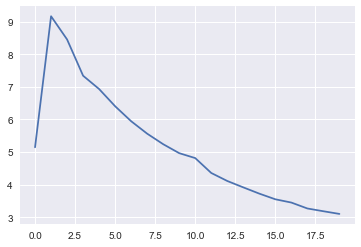

In [17]:
plt.plot(mean_freqs.index, np.log(mean_freqs))
plt.show()

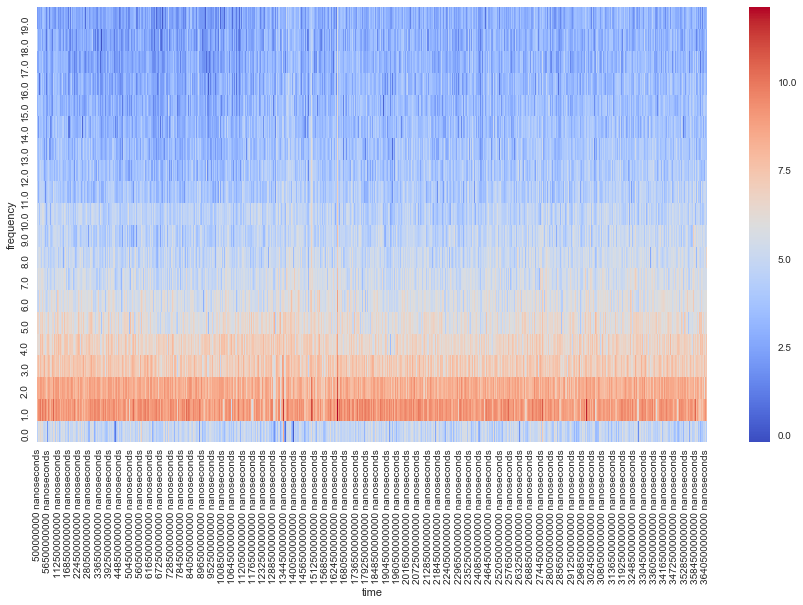

In [23]:
f, a = plt.subplots(figsize=(15,8))

a = sns.heatmap(np.log(df_lowf.transpose()), cmap='coolwarm')

a.invert_yaxis()
plt.show()